In [88]:
# importing required packages and libraries

import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score,roc_auc_score,roc_curve
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings("ignore")

In [12]:
# Load the transactions sheet in pandas dataframe
# Read only required columns to save memory
dft = pd.read_csv(r'C:\Users\pravi\Documents\Study\HSBC RC Hackathon 2025\Hackathon-2025-dev\Vikash\sample_transactions_2000_per_gemini.csv')


In [13]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       2000 non-null   object 
 1   originator_company   2000 non-null   object 
 2   originator_country   2000 non-null   object 
 3   beneficiary_company  2000 non-null   object 
 4   beneficiary_country  2000 non-null   object 
 5   amount               2000 non-null   float64
 6   currency             2000 non-null   object 
 7   date                 2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


In [14]:
# Drop transaction id
dft.drop(columns=['transaction_id'],axis=1,inplace=True)

In [15]:
dft.head()

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,date
0,Flores-Kim Group,Yemen,Ramirez-Brown Ltd,Mayotte,22927.11,USD,2025-02-07
1,Rodriguez-Thompson PLC,Falkland Islands (Malvinas),Gray and Sons,Guernsey,25118.58,USD,2025-03-20
2,Edwards-Miller Corporation,Saint Barthelemy,Morris Partners and Sons,North Korea,25668.85,USD,2025-05-23
3,Johnson LLC,Cuba,"Jones, Kim and Evans PLC",Rwanda,9523.10,USD,2025-06-11
4,Green Associates Corporation,Bulgaria,Thompson-Castillo Inc,Ghana,44517.08,USD,2025-01-23


In [16]:
# Load references sheet into dataframe
dfr = pd.read_csv(r'C:\Users\pravi\Documents\Study\HSBC RC Hackathon 2025\Hackathon-2025-dev\Vikash\company_mapping_per_gemini.csv')

In [17]:
dfr.head()

,company_name,country,sic_code,sic_description
0,Watson Industries and Sons,Guinea-Bissau,6719,"Offices of Holding Companies, Not Elsewhere Cl..."
1,"Foster, Mitchell and Stewart Company",Somalia,3714,Motor Vehicle Parts and Accessories
2,Garcia-Parker Group,Morocco,5162,Plastics Materials and Basic Forms and Shapes
3,"Taylor, Smith and Richardson Ltd",Tuvalu,3341,Secondary Smelting and Refining of Nonferrous ...
4,"Richardson, Cooper and Alvarez and Sons",Belize,7216,"Drycleaning Plants, Except Rug Cleaning"


In [19]:
# Are there any duplicates ?
dups = dfr['company_name'].duplicated(keep=False)
print('Number of duplicate rows = %d' % (dups.sum()))
dfr[dups]

Number of duplicate rows = 0


,company_name,country,sic_code,sic_description


In [20]:
# Number of unique company names
print("company_name column - Unique values:", dfr["company_name"].nunique(), "Total values:", dfr["company_name"].count())
print("sic_code column - Unique values:", dfr["sic_code"].nunique(), "Total values:", dfr["sic_code"].count())
print("sic_description column - Unique values:", dfr["sic_description"].nunique(), "Total values:", dfr["sic_description"].count())

company_name column - Unique values: 800 Total values: 800
sic_code column - Unique values: 557 Total values: 800
sic_description column - Unique values: 557 Total values: 800


In [21]:
# Creating backup copies
dft_bkp_1 = dft.copy()
dfr_bkp_1 = dfr.copy()

In [ ]:
# Revert back
#dft = dft_bkp_1.copy()
#dfr = dfr_bkp_1.copy()

In [22]:
dft.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,2000.0,26069.21614,14477.753333,136.04,13769.6575,26539.065,38747.875,49971.68


In [23]:
# Extract SIC code for an originator and beneficiary based on fuzzy logic on name and exact logic on country
# https://medium.com/@kasperjuunge/rapidfuzz-explained-c26e93b6012d

def fuzzy_match_id(name, country, df_ref, scorer=fuzz.WRatio, score_cutoff=80):
    if pd.isna(name) or pd.isna(country):
        return pd.NA, pd.NA
    
    # Filter df_ref by exact country match
    candidates = dfr[dfr['country'] == country]
    if candidates.empty:
        return pd.NA, pd.NA
    
    # Extract list of candidate names
    candidate_names = candidates['company_name'].tolist()
    
    # Fuzzy match the name against candidate names
    match = process.extractOne(name, candidate_names, scorer=scorer, score_cutoff=score_cutoff)
    if match:
        best_name, score, _ = match
        matched_row = candidates[candidates['company_name'] == best_name].iloc[0]
        matched_id = matched_row['sic_code']
        description = matched_row.get('sic_description', pd.NA)  # Use pd.NA if Description is missing
        return matched_id, description
    else:
        return pd.NA, pd.NA

# Apply fuzzy match lookup for originator
dft[['originator_id','originator_desc']] = dft.apply(
    lambda row: pd.Series(fuzzy_match_id(row['originator_company'], row['originator_country'], dfr)), axis=1)

# Apply fuzzy match lookup for beneficiary
dft[['beneficiary_id','beneficiary_desc']] = dft.apply(
    lambda row: pd.Series(fuzzy_match_id(row['beneficiary_company'], row['beneficiary_country'], dfr)), axis=1)


In [24]:
dft.head(10)

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,date,originator_id,originator_desc,beneficiary_id,beneficiary_desc
0,Flores-Kim Group,Yemen,Ramirez-Brown Ltd,Mayotte,22927.11,USD,2025-02-07,3451,Screw Machine Products,4941,Water Supply
1,Rodriguez-Thompson PLC,Falkland Islands (Malvinas),Gray and Sons,Guernsey,25118.58,USD,2025-03-20,2822,Synthetic Rubber (Vulcanizable Elastomers),3534,Elevators and Moving Stairways
2,Edwards-Miller Corporation,Saint Barthelemy,Morris Partners and Sons,North Korea,25668.85,USD,2025-05-23,3826,Laboratory Analytical Instruments,3821,Laboratory Apparatus and Furniture
3,Johnson LLC,Cuba,"Jones, Kim and Evans PLC",Rwanda,9523.10,USD,2025-06-11,2491,Wood Preserving,6719,"Offices of Holding Companies, Not Elsewhere Cl..."
4,Green Associates Corporation,Bulgaria,Thompson-Castillo Inc,Ghana,44517.08,USD,2025-01-23,2342,"Brassieres, Girdles, and Allied Garments",3363,Aluminum Die-Castings
5,Sanchez Industries Inc,Niger,Gonzalez Corporation,Falkland Islands (Malvinas),35705.52,USD,2025-06-25,2448,Wood Pallets and Skids,5046,"Commercial Equipment, Not Elsewhere Classified"
6,Carter PLC,Falkland Islands (Malvinas),"Roberts, Jackson and Ramirez LLC",Guyana,2397.16,USD,2025-02-21,7261,Funeral Service and Crematories,3562,Ball and Roller Bearings
7,"Anderson, Foster and Smith LLC",Iceland,Parker-Edwards and Sons,Norway,40794.94,USD,2025-04-05,9222,Legal Counsel and Prosecution,5551,Boat Dealers
8,Gray LLC,Uganda,Wilson LLC,United States of America,34731.72,USD,2025-03-09,2361,"Girls', Children's, and Infants' Dresses, Blou...",3295,"Minerals and Earths, Ground or Otherwise Treated"
9,Castillo Holdings Corporation,Gabon,"Rogers, Edwards and Wright Inc",Guatemala,36295.73,USD,2025-04-18,3953,Marking Devices,134,Irish Potatoes


In [25]:
# Checking NA records 
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   originator_company   2000 non-null   object 
 1   originator_country   2000 non-null   object 
 2   beneficiary_company  2000 non-null   object 
 3   beneficiary_country  2000 non-null   object 
 4   amount               2000 non-null   float64
 5   currency             2000 non-null   object 
 6   date                 2000 non-null   object 
 7   originator_id        2000 non-null   int64  
 8   originator_desc      2000 non-null   object 
 9   beneficiary_id       2000 non-null   int64  
 10  beneficiary_desc     2000 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 172.0+ KB


In [26]:
rows_with_na = dft[dft['originator_id'].isna() | dft['beneficiary_id'].isna()]
rows_with_na

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,date,originator_id,originator_desc,beneficiary_id,beneficiary_desc


In [27]:
# Shape before
dft.shape

(2000, 11)

In [28]:
# Write DataFrame to Excel
output_file = "transactions_sic_mapping.xlsx"
dft.to_excel(output_file, index=False)

Some EDA

For analysis on data, loading the generated excel

In [30]:
df_tran_withLabel = pd.read_excel(r'C:\Users\pravi\Documents\Study\HSBC RC Hackathon 2025\Hackathon-2025-dev\Vikash\transactions_sic_mapping_with_validity.xlsx', 
                    sheet_name='Sheet1')

In [31]:
df_tran_withLabel.head()

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,date,originator_id,originator_desc,beneficiary_id,beneficiary_desc,validity
0,Flores-Kim Group,Yemen,Ramirez-Brown Ltd,Mayotte,22927.11,USD,2025-02-07,3451,Screw Machine Products,4941,Water Supply,invalid
1,Rodriguez-Thompson PLC,Falkland Islands (Malvinas),Gray and Sons,Guernsey,25118.58,USD,2025-03-20,2822,Synthetic Rubber (Vulcanizable Elastomers),3534,Elevators and Moving Stairways,valid
2,Edwards-Miller Corporation,Saint Barthelemy,Morris Partners and Sons,North Korea,25668.85,USD,2025-05-23,3826,Laboratory Analytical Instruments,3821,Laboratory Apparatus and Furniture,valid
3,Johnson LLC,Cuba,"Jones, Kim and Evans PLC",Rwanda,9523.10,USD,2025-06-11,2491,Wood Preserving,6719,"Offices of Holding Companies, Not Elsewhere Cl...",valid
4,Green Associates Corporation,Bulgaria,Thompson-Castillo Inc,Ghana,44517.08,USD,2025-01-23,2342,"Brassieres, Girdles, and Allied Garments",3363,Aluminum Die-Castings,valid


In [33]:
df_tran_withLabel['validity'].replace('invalid', '0', inplace=True)
df_tran_withLabel['validity'].replace('valid', '1', inplace=True)

C:\Users\pravi\AppData\Local\Temp\ipykernel_23904\429653165.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_tran_withLabel['validity'].replace('invalid', '0', inplace=True)
C:\Users\pravi\AppData\Local\Temp\ipykernel_23904\429653165.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [34]:
df_tran_withLabel.head()

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,date,originator_id,originator_desc,beneficiary_id,beneficiary_desc,validity
0,Flores-Kim Group,Yemen,Ramirez-Brown Ltd,Mayotte,22927.11,USD,2025-02-07,3451,Screw Machine Products,4941,Water Supply,0
1,Rodriguez-Thompson PLC,Falkland Islands (Malvinas),Gray and Sons,Guernsey,25118.58,USD,2025-03-20,2822,Synthetic Rubber (Vulcanizable Elastomers),3534,Elevators and Moving Stairways,1
2,Edwards-Miller Corporation,Saint Barthelemy,Morris Partners and Sons,North Korea,25668.85,USD,2025-05-23,3826,Laboratory Analytical Instruments,3821,Laboratory Apparatus and Furniture,1
3,Johnson LLC,Cuba,"Jones, Kim and Evans PLC",Rwanda,9523.10,USD,2025-06-11,2491,Wood Preserving,6719,"Offices of Holding Companies, Not Elsewhere Cl...",1
4,Green Associates Corporation,Bulgaria,Thompson-Castillo Inc,Ghana,44517.08,USD,2025-01-23,2342,"Brassieres, Girdles, and Allied Garments",3363,Aluminum Die-Castings,1


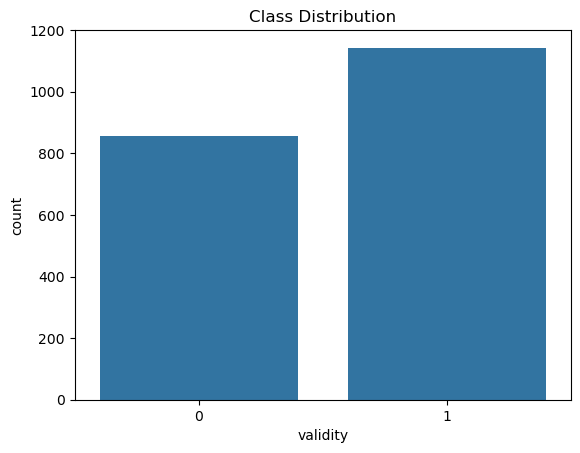

In [35]:
# Plotting class distribution
sns.countplot(x='validity', data=df_tran_withLabel)
plt.title("Class Distribution")
plt.show()

In [36]:
# Finding number of unique value of categorical variables from total count
print("originator_company column - Unique values:", df_tran_withLabel["originator_company"].nunique(), "Total values:", df_tran_withLabel["originator_company"].count())
print("beneficiary_company column - Unique values:", df_tran_withLabel["beneficiary_company"].nunique(), "Total values:", df_tran_withLabel["beneficiary_company"].count())
print("originator_desc column - Unique values:", df_tran_withLabel["originator_desc"].nunique(), "Total values:", df_tran_withLabel["originator_desc"].count())
print("beneficiary_desc column - Unique values:", df_tran_withLabel["beneficiary_desc"].nunique(), "Total values:", df_tran_withLabel["beneficiary_desc"].count())

originator_company column - Unique values: 736 Total values: 2000
beneficiary_company column - Unique values: 728 Total values: 2000
originator_desc column - Unique values: 526 Total values: 2000
beneficiary_desc column - Unique values: 525 Total values: 2000


In [39]:
print("validity column - Unique values:", df_tran_withLabel["validity"].nunique(), "Total values:", df_tran_withLabel["validity"].count())
df_tran_withLabel["validity"].value_counts()

validity column - Unique values: 2 Total values: 2000


validity
1    1143
0     857
Name: count, dtype: int64

Iteration 1

In [43]:
# Defining features and target
#features = ["originator_company", "beneficiary_company", "originator_desc", "beneficiary_desc", "originator_id", "beneficiary_id"]
features = ["originator_company", "originator_country", "beneficiary_company", "beneficiary_country", "originator_desc", "beneficiary_desc"]
target = ["validity"]

In [44]:
cat_features = ["originator_company", "originator_country", "beneficiary_company", "beneficiary_country", "originator_desc", "beneficiary_desc"]

In [45]:
# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(df_tran_withLabel[features], df_tran_withLabel[target], test_size=0.2, random_state=10, stratify=df_tran_withLabel[target])
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1600, 6)
X_test shape: (400, 6)
y_train shape: (1600, 1)
y_test shape: (400, 1)


In [46]:
# Train the model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    verbose=50)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=30)

0:	test: 0.7616257	best: 0.7616257 (0)	total: 273ms	remaining: 2m 16s
50:	test: 0.8293879	best: 0.8303838 (45)	total: 2.03s	remaining: 17.9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8303838198
bestIteration = 45

Shrink model to first 46 iterations.


In [47]:
# Prediction
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [48]:
unique_values, counts = np.unique(y_pred_train, return_counts=True)
print("Train Data - Unique Values:", unique_values, "Counts:", counts)
unique_values, counts = np.unique(y_pred_test, return_counts=True)
print("Test Data - Unique Values:", unique_values, "Counts:", counts)

Train Data - Unique Values: ['0' '1'] Counts: [715 885]
Test Data - Unique Values: ['0' '1'] Counts: [147 253]


In [49]:
# Evaluating the model
print("Train report")
print(classification_report(y_train, y_pred_train))
print("Test report")
print(classification_report(y_test, y_pred_test))

Train report
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       686
           1       0.94      0.91      0.93       914

    accuracy                           0.92      1600
   macro avg       0.91      0.92      0.92      1600
weighted avg       0.92      0.92      0.92      1600

Test report
              precision    recall  f1-score   support

           0       0.73      0.63      0.67       171
           1       0.75      0.83      0.78       229

    accuracy                           0.74       400
   macro avg       0.74      0.73      0.73       400
weighted avg       0.74      0.74      0.74       400



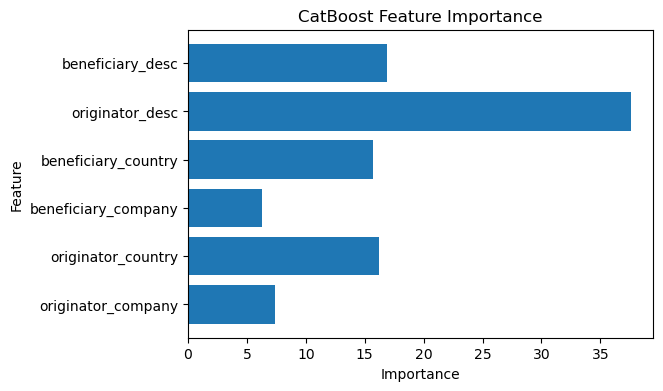

In [50]:
# Feature importance
import matplotlib.pyplot as plt

feature_importances = model.get_feature_importance(train_pool)
plt.figure(figsize=(6,4))
plt.barh(X_train.columns, feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Feature Importance")
plt.show()


Iteration 2

In [51]:
model2 = CatBoostClassifier(loss_function='Logloss', eval_metric='F1', random_seed=42, verbose=0)

param_grid = {
    'iterations': [100, 300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    
}

In [52]:
grid_result = model2.grid_search(
    param_grid,
    X=train_pool,
    cv=3,
    shuffle=True,
    stratified=True,
    plot=False  # Set True if you want live charts
)


bestTest = 0.7692307692
bestIteration = 0

0:	loss: 0.7692308	best: 0.7692308 (0)	total: 2.92s	remaining: 3m 53s

bestTest = 0.7692307692
bestIteration = 0

1:	loss: 0.7692308	best: 0.7692308 (0)	total: 5.93s	remaining: 3m 54s

bestTest = 0.7692307692
bestIteration = 0

2:	loss: 0.7692308	best: 0.7692308 (0)	total: 8.83s	remaining: 3m 49s

bestTest = 0.7692307692
bestIteration = 0

3:	loss: 0.7692308	best: 0.7692308 (0)	total: 11.6s	remaining: 3m 43s

bestTest = 0.7692307692
bestIteration = 0

4:	loss: 0.7692308	best: 0.7692308 (0)	total: 14.6s	remaining: 3m 41s

bestTest = 0.7692307692
bestIteration = 0

5:	loss: 0.7692308	best: 0.7692308 (0)	total: 17.5s	remaining: 3m 38s

bestTest = 0.7692307692
bestIteration = 0

6:	loss: 0.7692308	best: 0.7692308 (0)	total: 20.2s	remaining: 3m 33s

bestTest = 0.7692307692
bestIteration = 0

7:	loss: 0.7692308	best: 0.7692308 (0)	total: 23s	remaining: 3m 29s

bestTest = 0.7692307692
bestIteration = 0

8:	loss: 0.7692308	best: 0.7692308 (0)	total: 

In [53]:
# Get best parameters
# Best parameters
best_params = grid_result['params']
print("Best Parameters Found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")

Best Parameters Found:
   depth: 8
   learning_rate: 0.05
   l2_leaf_reg: 5
   iterations: 300


In [54]:
# Train model with best parameters
best_model = CatBoostClassifier(**best_params, loss_function='Logloss', eval_metric='F1', verbose=0, random_seed=42)

# Train using train_pool & validate on test_pool
best_model.fit(train_pool, eval_set=test_pool, use_best_model=True)


In [55]:
ytrain_predict_cl = best_model.predict(X_train)
ytest_predict_cl = best_model.predict(X_test)

In [56]:
print('Accuracy Score for train dataset is',round(accuracy_score(y_train, ytrain_predict_cl),2)*100,'%')
print("\n")
print('Accuracy Score for test dataset is',round(accuracy_score(y_test, ytest_predict_cl),2)*100,'%')

Accuracy Score for train dataset is 94.0 %


Accuracy Score for test dataset is 76.0 %


In [57]:
unique_values, counts = np.unique(y_pred_train, return_counts=True)
print("Train Data - Unique Values:", unique_values, "Counts:", counts)
unique_values, counts = np.unique(y_pred_test, return_counts=True)
print("Test Data - Unique Values:", unique_values, "Counts:", counts)

Train Data - Unique Values: ['0' '1'] Counts: [715 885]
Test Data - Unique Values: ['0' '1'] Counts: [147 253]


Trying another method of different features

In [58]:
df_tran_withLabel.head(10)

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,date,originator_id,originator_desc,beneficiary_id,beneficiary_desc,validity
0,Flores-Kim Group,Yemen,Ramirez-Brown Ltd,Mayotte,22927.11,USD,2025-02-07,3451,Screw Machine Products,4941,Water Supply,0
1,Rodriguez-Thompson PLC,Falkland Islands (Malvinas),Gray and Sons,Guernsey,25118.58,USD,2025-03-20,2822,Synthetic Rubber (Vulcanizable Elastomers),3534,Elevators and Moving Stairways,1
2,Edwards-Miller Corporation,Saint Barthelemy,Morris Partners and Sons,North Korea,25668.85,USD,2025-05-23,3826,Laboratory Analytical Instruments,3821,Laboratory Apparatus and Furniture,1
3,Johnson LLC,Cuba,"Jones, Kim and Evans PLC",Rwanda,9523.10,USD,2025-06-11,2491,Wood Preserving,6719,"Offices of Holding Companies, Not Elsewhere Cl...",1
4,Green Associates Corporation,Bulgaria,Thompson-Castillo Inc,Ghana,44517.08,USD,2025-01-23,2342,"Brassieres, Girdles, and Allied Garments",3363,Aluminum Die-Castings,1
5,Sanchez Industries Inc,Niger,Gonzalez Corporation,Falkland Islands (Malvinas),35705.52,USD,2025-06-25,2448,Wood Pallets and Skids,5046,"Commercial Equipment, Not Elsewhere Classified",1
6,Carter PLC,Falkland Islands (Malvinas),"Roberts, Jackson and Ramirez LLC",Guyana,2397.16,USD,2025-02-21,7261,Funeral Service and Crematories,3562,Ball and Roller Bearings,0
7,"Anderson, Foster and Smith LLC",Iceland,Parker-Edwards and Sons,Norway,40794.94,USD,2025-04-05,9222,Legal Counsel and Prosecution,5551,Boat Dealers,1
8,Gray LLC,Uganda,Wilson LLC,United States of America,34731.72,USD,2025-03-09,2361,"Girls', Children's, and Infants' Dresses, Blou...",3295,"Minerals and Earths, Ground or Otherwise Treated",1
9,Castillo Holdings Corporation,Gabon,"Rogers, Edwards and Wright Inc",Guatemala,36295.73,USD,2025-04-18,3953,Marking Devices,134,Irish Potatoes,1


In [59]:
# Create some simple features
df_tran_withLabel["sam
e_industry"] = (df_tran_withLabel["originator_id"] == df_tran_withLabel["beneficiary_id"]).astype(int)
df_tran_withLabel["amount_log"] = np.log1p(df_tran_withLabel["amount"])

In [60]:
df_tran_withLabel.head()

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,date,originator_id,originator_desc,beneficiary_id,beneficiary_desc,validity,same_industry,amount_log
0,Flores-Kim Group,Yemen,Ramirez-Brown Ltd,Mayotte,22927.11,USD,2025-02-07,3451,Screw Machine Products,4941,Water Supply,0,0,10.040119
1,Rodriguez-Thompson PLC,Falkland Islands (Malvinas),Gray and Sons,Guernsey,25118.58,USD,2025-03-20,2822,Synthetic Rubber (Vulcanizable Elastomers),3534,Elevators and Moving Stairways,1,0,10.131403
2,Edwards-Miller Corporation,Saint Barthelemy,Morris Partners and Sons,North Korea,25668.85,USD,2025-05-23,3826,Laboratory Analytical Instruments,3821,Laboratory Apparatus and Furniture,1,0,10.153072
3,Johnson LLC,Cuba,"Jones, Kim and Evans PLC",Rwanda,9523.10,USD,2025-06-11,2491,Wood Preserving,6719,"Offices of Holding Companies, Not Elsewhere Cl...",1,0,9.161581
4,Green Associates Corporation,Bulgaria,Thompson-Castillo Inc,Ghana,44517.08,USD,2025-01-23,2342,"Brassieres, Girdles, and Allied Garments",3363,Aluminum Die-Castings,1,0,10.703651


In [61]:
df_tran_withLabel["same_industry"].value_counts()

same_industry
0    1998
1       2
Name: count, dtype: int64

In [62]:
# Defining features and target
features = ["originator_id", "originator_country", "beneficiary_id", "beneficiary_country", "amount_log", "same_industry"]
target = ["validity"]

In [63]:
cat_features = ["originator_id", "beneficiary_id", "originator_country", "beneficiary_country"]

In [64]:
# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(df_tran_withLabel[features], df_tran_withLabel[target], test_size=0.2, random_state=10, stratify=df_tran_withLabel[target])
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1600, 6)
X_test shape: (400, 6)
y_train shape: (1600, 1)
y_test shape: (400, 1)


In [65]:
# Train the model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [66]:
model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_seed=42, verbose=0)

param_grid = {
    'iterations': [100, 300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    
}

In [67]:
grid_result = model.grid_search(
    param_grid,
    X=train_pool,
    cv=3,
    shuffle=True,
    stratified=True,
    plot=False  # Set True if you want live charts
)


bestTest = 0.785708554
bestIteration = 11

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.7857086	best: 0.7857086 (0)	total: 1.61s	remaining: 2m 8s

bestTest = 0.8124297866
bestIteration = 84

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8124298	best: 0.8124298 (1)	total: 3.15s	remaining: 2m 4s

bestTest = 0.8097416145
bestIteration = 67

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8097416	best: 0.8124298 (1)	total: 4.83s	remaining: 2m 5s

bestTest = 0.7845249559
bestIteration = 14

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.7845250	best: 0.8124298 (1)	total: 6.4s	remaining: 2m 3s

bestTest 

In [68]:
# Get best parameters
# Best parameters
best_params = grid_result['params']
print("Best Parameters Found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")

Best Parameters Found:
   depth: 4
   learning_rate: 0.05
   l2_leaf_reg: 5
   iterations: 500


In [69]:
# Train model with best parameters
best_model = CatBoostClassifier(**best_params, loss_function='Logloss', eval_metric='F1', verbose=0, random_seed=42)

# Train using train_pool & validate on test_pool
best_model.fit(train_pool, eval_set=test_pool, use_best_model=True)


In [70]:
ytrain_predict_cl = best_model.predict(X_train)
ytest_predict_cl = best_model.predict(X_test)

In [71]:
print('Accuracy Score for train dataset is',round(accuracy_score(y_train, ytrain_predict_cl),2)*100,'%')
print("\n")
print('Accuracy Score for test dataset is',round(accuracy_score(y_test, ytest_predict_cl),2)*100,'%')

Accuracy Score for train dataset is 90.0 %


Accuracy Score for test dataset is 77.0 %


In [72]:
unique_values, counts = np.unique(y_pred_train, return_counts=True)
print("Train Data - Unique Values:", unique_values, "Counts:", counts)
unique_values, counts = np.unique(y_pred_test, return_counts=True)
print("Test Data - Unique Values:", unique_values, "Counts:", counts)

Train Data - Unique Values: ['0' '1'] Counts: [715 885]
Test Data - Unique Values: ['0' '1'] Counts: [147 253]


In [73]:
# Evaluating the model
print("Train report")
print(classification_report(y_train, y_pred_train))
print("Test report")
print(classification_report(y_test, y_pred_test))

Train report
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       686
           1       0.94      0.91      0.93       914

    accuracy                           0.92      1600
   macro avg       0.91      0.92      0.92      1600
weighted avg       0.92      0.92      0.92      1600

Test report
              precision    recall  f1-score   support

           0       0.73      0.63      0.67       171
           1       0.75      0.83      0.78       229

    accuracy                           0.74       400
   macro avg       0.74      0.73      0.73       400
weighted avg       0.74      0.74      0.74       400



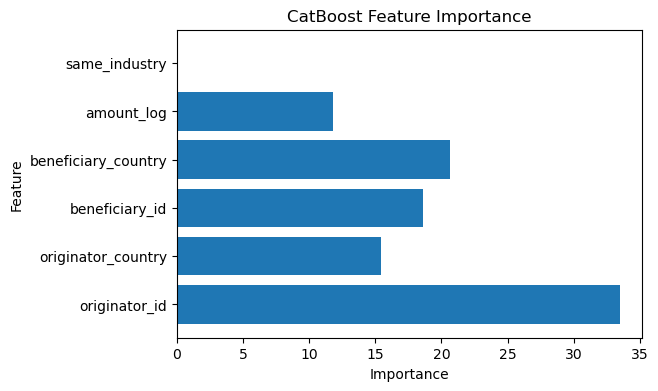

In [74]:
# Feature importance
import matplotlib.pyplot as plt

feature_importances = model.get_feature_importance(train_pool)
plt.figure(figsize=(6,4))
plt.barh(X_train.columns, feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Feature Importance")
plt.show()

KNN model

In [75]:
# Defining features and target
features = ["originator_id", "beneficiary_id", "amount_log", "same_industry"]
target = ["validity"]

In [76]:
df_tran_withLabel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   originator_company   2000 non-null   object 
 1   originator_country   2000 non-null   object 
 2   beneficiary_company  2000 non-null   object 
 3   beneficiary_country  2000 non-null   object 
 4   amount               2000 non-null   float64
 5   currency             2000 non-null   object 
 6   date                 2000 non-null   object 
 7   originator_id        2000 non-null   int64  
 8   originator_desc      2000 non-null   object 
 9   beneficiary_id       2000 non-null   int64  
 10  beneficiary_desc     2000 non-null   object 
 11  validity             2000 non-null   object 
 12  same_industry        2000 non-null   int32  
 13  amount_log           2000 non-null   float64
dtypes: float64(2), int32(1), int64(2), object(9)
memory usage: 211.1+ KB


In [78]:
# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(df_tran_withLabel[features], df_tran_withLabel[target], test_size=0.3, random_state=10, stratify=df_tran_withLabel[target])
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1400, 4)
X_test shape: (600, 4)
y_train shape: (1400, 1)
y_test shape: (600, 1)


In [84]:
grid={'n_neighbors': [3,5,10],
      'weights':['distance','uniform'],
      'metric':['chebyshev','distance','cosine']}

KNN_model_fitted = KNeighborsClassifier()

grid_search = GridSearchCV(estimator = KNN_model_fitted, param_grid = grid, cv = 3, n_jobs=-1)


In [85]:
grid_search.fit(X_train, y_train)

C:\Users\pravi\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\pravi\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pravi\anaconda3\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\pravi\anaconda3\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\pravi\anaconda3\Lib\site-packages\s

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['chebyshev', 'distance', 'cosine'],
                         'n_neighbors': [3, 5, 10],
                         'weights': ['distance', 'uniform']})

In [93]:
KNN_best_model = grid_search.best_estimator_
print(KNN_best_model)

KNeighborsClassifier(metric='chebyshev', n_neighbors=10, weights='distance')


In [90]:
ytrain_predict_knn = KNN_best_model.predict(X_train)
ytest_predict_knn = KNN_best_model.predict(X_test)

In [92]:
print('Accuracy Score for train dataset is',round(accuracy_score(y_train, ytrain_predict_knn),2)*100,'%')
print("\n")
print('Accuracy Score for test dataset is',round(accuracy_score(y_test, ytest_predict_knn),2)*100,'%')

Accuracy Score for train dataset is 100.0 %


Accuracy Score for test dataset is 79.0 %


In [94]:
unique_values, counts = np.unique(ytrain_predict_knn, return_counts=True)
print("Train Data - Unique Values:", unique_values, "Counts:", counts)
unique_values, counts = np.unique(ytest_predict_knn, return_counts=True)
print("Test Data - Unique Values:", unique_values, "Counts:", counts)

Train Data - Unique Values: ['0' '1'] Counts: [600 800]
Test Data - Unique Values: ['0' '1'] Counts: [269 331]


In [95]:
# Evaluating the model
print("Train report")
print(classification_report(y_train, ytrain_predict_knn))
print("Test report")
print(classification_report(y_test, ytest_predict_knn))

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       800

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400

Test report
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       257
           1       0.83      0.80      0.81       343

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600



Trying Neural Network

In [96]:
from sklearn.neural_network import MLPClassifier

In [99]:
df_tran_withLabel[features].head()

,originator_id,beneficiary_id,amount_log,same_industry
0,3451,4941,10.040119,0
1,2822,3534,10.131403,0
2,3826,3821,10.153072,0
3,2491,6719,9.161581,0
4,2342,3363,10.703651,0


In [100]:
df_tran_withLabel[target].head()

,validity
0,0
1,1
2,1
3,1
4,1


In [101]:
df_tran_withLabel[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   originator_id   2000 non-null   int64  
 1   beneficiary_id  2000 non-null   int64  
 2   amount_log      2000 non-null   float64
 3   same_industry   2000 non-null   int32  
dtypes: float64(1), int32(1), int64(2)
memory usage: 54.8 KB


In [102]:
df_tran_withLabel[target].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   validity  2000 non-null   object
dtypes: object(1)
memory usage: 15.8+ KB


In [103]:
df_tran_withLabel['validity'] = df_tran_withLabel['validity'].astype(int)

In [104]:
df_tran_withLabel[target].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   validity  2000 non-null   int32
dtypes: int32(1)
memory usage: 7.9 KB


In [105]:
# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(df_tran_withLabel[features], df_tran_withLabel[target], test_size=0.3, random_state=10, stratify=df_tran_withLabel[target])
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1400, 4)
X_test shape: (600, 4)
y_train shape: (1400, 1)
y_test shape: (600, 1)


In [106]:
# Initialize the Multi-layer Perceptron (MLP) Classifier
# hidden_layer_sizes=(64, 32) defines a network with two hidden layers of 64 and 32 neurons respectively.
model_nn = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',          # Standard activation function for hidden layers
    solver='adam',              # Efficient optimizer
    max_iter=100,               # Number of training epochs
    random_state=42,
    early_stopping=True,        # Stops training when validation score is not improving
    verbose=False
)


In [107]:
# Train the model on the scaled training data
model_nn.fit(X_train, y_train)


MLPClassifier(early_stopping=True, hidden_layer_sizes=(64, 32), max_iter=100,
              random_state=42)

In [108]:
ytrain_predict_nn = model_nn.predict(X_train)
ytest_predict_nn = model_nn.predict(X_test)

In [109]:
print('Accuracy Score for train dataset is',round(accuracy_score(y_train, ytrain_predict_nn),2)*100,'%')
print("\n")
print('Accuracy Score for test dataset is',round(accuracy_score(y_test, ytest_predict_nn),2)*100,'%')

Accuracy Score for train dataset is 64.0 %


Accuracy Score for test dataset is 61.0 %


In [110]:
unique_values, counts = np.unique(ytrain_predict_nn, return_counts=True)
print("Train Data - Unique Values:", unique_values, "Counts:", counts)
unique_values, counts = np.unique(ytest_predict_nn, return_counts=True)
print("Test Data - Unique Values:", unique_values, "Counts:", counts)

Train Data - Unique Values: [0 1] Counts: [439 961]
Test Data - Unique Values: [0 1] Counts: [188 412]


In [111]:
# Evaluating the model
print("Train report")
print(classification_report(y_train, ytrain_predict_nn))
print("Test report")
print(classification_report(y_test, ytest_predict_nn))

Train report
              precision    recall  f1-score   support

           0       0.61      0.45      0.51       600
           1       0.65      0.79      0.71       800

    accuracy                           0.64      1400
   macro avg       0.63      0.61      0.61      1400
weighted avg       0.63      0.64      0.63      1400

Test report
              precision    recall  f1-score   support

           0       0.57      0.42      0.48       257
           1       0.64      0.76      0.69       343

    accuracy                           0.61       600
   macro avg       0.60      0.59      0.59       600
weighted avg       0.61      0.61      0.60       600



Trying grid search cv

In [112]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],  # Neurons per layer
    'activation': ['tanh', 'relu', 'logistic'],                # Activation functions
    'solver': ['adam', 'sgd'],                                 # Optimizers
    'alpha': [0.0001, 0.001, 0.01],                            # L2 regularization
    'learning_rate': ['constant', 'adaptive'],                 # Learning rate strategies
    'max_iter': [200, 400]                                     # Number of iterations
}

In [113]:
model_mlp = MLPClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=model_mlp,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,          # Use all CPU cores
    cv=5,               # 5-fold cross-validation
    verbose=2
)


In [114]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu', 'logistic'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [200, 400], 'solver': ['adam', 'sgd']},
             scoring='accuracy', verbose=2)

In [115]:
best_mlp = grid_search.best_estimator_

In [116]:
print(best_mlp)

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(50, 50),
              random_state=42)


In [117]:
ytrain_predict_nn_cv = best_mlp.predict(X_train)
ytest_predict_nn_cv = best_mlp.predict(X_test)

In [118]:
print('Accuracy Score for train dataset is',round(accuracy_score(y_train, ytrain_predict_nn_cv),2)*100,'%')
print("\n")
print('Accuracy Score for test dataset is',round(accuracy_score(y_test, ytest_predict_nn_cv),2)*100,'%')

Accuracy Score for train dataset is 70.0 %


Accuracy Score for test dataset is 66.0 %


In [119]:
unique_values, counts = np.unique(ytrain_predict_nn_cv, return_counts=True)
print("Train Data - Unique Values:", unique_values, "Counts:", counts)
unique_values, counts = np.unique(ytest_predict_nn_cv, return_counts=True)
print("Test Data - Unique Values:", unique_values, "Counts:", counts)

Train Data - Unique Values: [0 1] Counts: [751 649]
Test Data - Unique Values: [0 1] Counts: [309 291]


In [120]:
# Evaluating the model
print("Train report")
print(classification_report(y_train, ytrain_predict_nn_cv))
print("Test report")
print(classification_report(y_test, ytest_predict_nn_cv))

Train report
              precision    recall  f1-score   support

           0       0.62      0.78      0.69       600
           1       0.79      0.64      0.71       800

    accuracy                           0.70      1400
   macro avg       0.71      0.71      0.70      1400
weighted avg       0.72      0.70      0.70      1400

Test report
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       257
           1       0.74      0.63      0.68       343

    accuracy                           0.66       600
   macro avg       0.66      0.67      0.66       600
weighted avg       0.67      0.66      0.66       600



In [121]:
# Saving model as pkl file
with open('TransactionAnalysis_mlp.pkl', 'wb') as f:
    pickle.dump(best_mlp,f)